In [1]:
import MetaTrader5 as mt5
import pandas as pd
import pandas_ta as ta
import mplfinance as mpf

from typing import List, Optional

In [2]:
mt5.initialize()

True

In [3]:
def get_highest_pivot_bar(df: pd.DataFrame, pivot_bar: pd.Series, window_size: int = 2) -> pd.Series:
    left_bars = df[df['time'] < pivot_bar['time']].tail(window_size)
    right_bars = df[df['time'] > pivot_bar['time']].head(window_size)

    merged_df = pd.concat([left_bars, right_bars])
    highest_bar = merged_df.nlargest(1, 'high')
    highest_bar = highest_bar.iloc[-1]

    return pivot_bar if highest_bar['high'] < pivot_bar['high'] else highest_bar

def get_lowest_pivot_bar(df: pd.DataFrame, pivot_bar: pd.Series, window_size: int = 2) -> pd.Series:
    left_bars = df[df['time'] < pivot_bar['time']].tail(window_size)
    right_bars = df[df['time'] > pivot_bar['time']].head(window_size)
    
    merged_df = pd.concat([left_bars, right_bars])
    lowest_bar = merged_df.nsmallest(1, 'low')
    lowest_bar = lowest_bar.iloc[-1]

    return pivot_bar if lowest_bar['low'] > pivot_bar['low'] else lowest_bar

def is_bearish_divergence(df: pd.DataFrame, current_pivot_high: pd.Series) -> Optional[pd.Series]:
    nearest_rsi_pivot_high = df[(df['rsi_pivot_high']) & (df['time'] < current_pivot_high['time']) & (df['rsi'] > current_pivot_high['rsi'])]
        
    if not nearest_rsi_pivot_high.empty:
        nearest_rsi_pivot_high = nearest_rsi_pivot_high.iloc[-1]
        
        if nearest_rsi_pivot_high['rsi'] > 60:
            current_pivot_high = get_highest_pivot_bar(df, current_pivot_high)
            nearest_pivot_high_candle = get_highest_pivot_bar(df, nearest_rsi_pivot_high)
            
            if current_pivot_high['high'] > nearest_pivot_high_candle['high']:
                return nearest_rsi_pivot_high
    
    return None

def is_bullish_divergence(df: pd.DataFrame, current_pivot_low: pd.Series) -> Optional[pd.Series]:
    nearest_rsi_pivot_low = df[(df['rsi_pivot_low']) & (df['time'] < current_pivot_low['time']) & (df['rsi'] < current_pivot_low['rsi'])]
    if not nearest_rsi_pivot_low.empty:
        nearest_rsi_pivot_low = nearest_rsi_pivot_low.iloc[-1]

        if nearest_rsi_pivot_low['rsi'] < 40:
            current_pivot_low = get_lowest_pivot_bar(df, current_pivot_low)
            nearest_pivot_low_candle = get_lowest_pivot_bar(df, nearest_rsi_pivot_low)

            if current_pivot_low['low'] < nearest_pivot_low_candle['low']:
                return nearest_rsi_pivot_low
            
    return None
    
def detect_divergence(df: pd.DataFrame):
    price_lines = []
    rsi_lines = []
    
    for _, current_candle in df.iterrows():
        if current_candle['rsi_pivot_low']:
            bullish_divergence_point = is_bullish_divergence(df, current_candle)
            if bullish_divergence_point is not None:
                rsi_lines.append([
                    (bullish_divergence_point['time'], bullish_divergence_point['rsi']),
                    (current_candle['time'], current_candle['rsi'])
                ])
                
                current_candle = get_lowest_pivot_bar(df, current_candle)
                nearest_pivot_low_candle = get_lowest_pivot_bar(df, bullish_divergence_point)
                price_lines.append([
                    (nearest_pivot_low_candle['time'], nearest_pivot_low_candle['low']),
                    (current_candle['time'], current_candle['low'])
                ])

        if current_candle['rsi_pivot_high']:
            bearish_divergence_point = is_bearish_divergence(df, current_candle)
            if bearish_divergence_point is not None:
                rsi_lines.append([
                    (bearish_divergence_point['time'], bearish_divergence_point['rsi']),
                    (current_candle['time'], current_candle['rsi'])
                ])

                current_candle = get_highest_pivot_bar(df, current_candle)
                nearest_pivot_high_candle = get_highest_pivot_bar(df, bearish_divergence_point)
                price_lines.append([
                    (nearest_pivot_high_candle['time'], nearest_pivot_high_candle['high']),
                    (current_candle['time'], current_candle['high'])
                ])

    return price_lines, rsi_lines

In [ ]:
rates = mt5.copy_rates_from_pos('BTCUSD', mt5.TIMEFRAME_H4, 0, 200)

df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')

bb = ta.bbands(df['close'], 20, 2)

df['bb_l'] = bb.iloc[:,0]
df['bb_u'] = bb.iloc[:,2]

df['position'] = (df['close'] - df['bb_l']) / (df['bb_u'] - df['bb_l'])

df.tail(40)

,time,open,high,low,close,tick_volume,spread,real_volume,bb_l,bb_u,position
160,2024-08-03 20:00:00,60169.83,60847.29,59798.23,60687.53,44830,266,0,60082.445059,66231.123941,0.098409
161,2024-08-04 00:00:00,60687.69,61110.38,60273.69,60708.20,44631,267,0,59838.813129,66018.245871,0.140690
162,2024-08-04 04:00:00,60708.20,60916.17,60206.62,60328.36,35273,294,0,59530.059084,65896.719916,0.125388
163,2024-08-04 08:00:00,60328.36,60993.82,60048.78,60873.41,42993,197,0,59330.912159,65794.560841,0.238642
164,2024-08-04 12:00:00,60873.42,61082.08,58859.84,59004.14,58528,0,0,58820.545984,65775.112016,0.026399
165,2024-08-04 16:00:00,59004.14,59444.33,56990.82,59205.60,79789,264,0,58479.792824,65567.431176,0.102405
166,2024-08-04 20:00:00,59205.60,59545.72,57929.28,58096.12,55634,150,0,57876.871089,65693.712911,0.028048
167,2024-08-05 00:00:00,58105.42,58246.20,52230.45,53872.69,123658,0,0,56173.036851,66447.627149,-0.223887
168,2024-08-05 04:00:00,53872.69,54549.80,48952.21,52715.52,135859,0,0,54649.618655,66711.001345,-0.160355
169,2024-08-05 08:00:00,52715.05,53286.51,50655.25,51370.56,117980,0,0,53025.634485,67014.198515,-0.118316


Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\NCPC\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\NCPC\AppData\Local\Programs\Python\Python310\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\NCPC\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\NCPC\AppData\Local\Programs\Python\Python310\lib\asyncio\selector_events.py", line 115, in _read_from_self
 

In [16]:

df['rsi'] = ta.rsi(df['close'], 14)
df['atr'] = ta.atr(df['high'], df['low'], df['close'], 14)

df.dropna(inplace=True)
df.set_index(df['time'], inplace=True)

window_size = 3
df['rsi_pivot_high'] = df['rsi'] == df['rsi'].rolling(2 * window_size + 1, center=True).max()
df['rsi_pivot_low'] = df['rsi'] == df['rsi'].rolling(2 * window_size + 1, center=True).min()


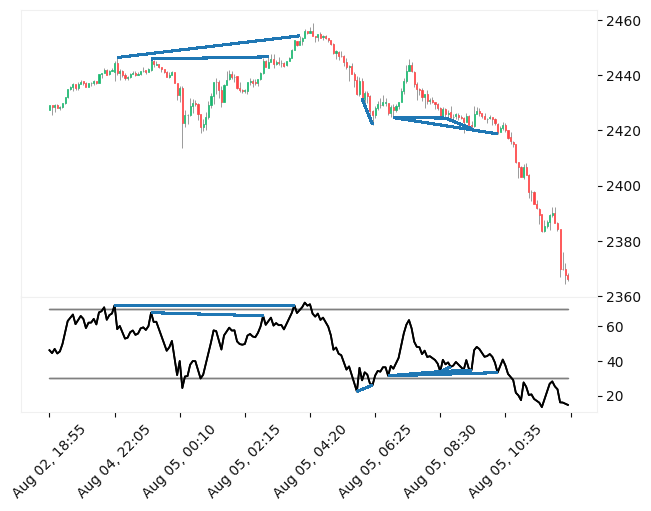

Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\NCPC\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\NCPC\AppData\Local\Programs\Python\Python310\lib\asyncio\selector_events.py", line 115, in _read_from_self
    data = self._ssock.recv(4096)
ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host
Exception in callback BaseSelectorEventLoop._read_from_self()
handle: <Handle BaseSelectorEventLoop._read_from_self()>
Traceback (most recent call last):
  File "C:\Users\NCPC\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\NCPC\AppData\Local\Programs\Python\Python310\lib\asyncio\selector_events.py", line 115, in _read_from_self
 

In [ ]:
df = df.tail(200)
price_lines, rsi_lines = detect_divergence(df)

plots = [
    mpf.make_addplot(df['rsi'], panel=1, color='black', fill_between=dict(y1=30, y2=30, color="gray")),
    mpf.make_addplot(df['rsi'], panel=1, color='black', fill_between=dict(y1=70, y2=70, color="gray")),
]

style = mpf.make_mpf_style(base_mpf_style='yahoo', rc={'grid.alpha':0}, figcolor='#fff', facecolor="#fff")
_, axs = mpf.plot(
    df,
    type='candle',
    style=style,
    volume=False,
    ylabel='',
    ylabel_lower='',
    addplot=plots,
    returnfig=True,
    alines=dict(alines=price_lines))

rsi_lines = mpf._utils._construct_aline_collections(dict(alines=rsi_lines), df.index)
axs[2].add_collection(rsi_lines);

In [8]:
symbol = 'BTCUSD'
risk_amount = 30
order_type = mt5.ORDER_TYPE_SELL
info_tick = mt5.symbol_info_tick(symbol)
atr = df['atr'].iloc[-2]

entry = 0
stop_loss = 0

match order_type:
    case mt5.ORDER_TYPE_BUY:
        entry = info_tick.ask
        stop_loss = entry - atr * 5
    case mt5.ORDER_TYPE_SELL:
        entry = info_tick.bid
        stop_loss = entry + atr * 5

trade_volume = risk_amount / abs(entry - stop_loss)
trade_volume = round(trade_volume, 2)

request = {
    'action': mt5.TRADE_ACTION_DEAL,
    'symbol': symbol,
    'deviation': 10,
    'type': order_type,
    'volume': trade_volume,
    'price': entry,
    'sl': stop_loss
}
result = mt5.order_send(request)
result

OrderSendResult(retcode=10009, deal=156569646, order=208562880, volume=0.03, price=63165.37, bid=63165.37, ask=63168.75, comment='', request_id=2384262747, retcode_external=0, request=TradeRequest(action=1, magic=0, order=0, symbol='BTCUSD', volume=0.03, price=63165.37, stoplimit=0.0, sl=64188.99960187674, tp=0.0, deviation=10, type=1, type_filling=0, type_time=0, expiration=0, comment='', position=0, position_by=0))

In [6]:
positions = mt5.positions_get(symbol='GBPUSD')
positions

(TradePosition(ticket=210024869, time=1721231116, time_msc=1721231116001, time_update=1721231116, time_update_msc=1721231116001, type=0, magic=0, identifier=210024869, reason=3, volume=0.2, price_open=1.30034, sl=1.2978100000000001, tp=0.0, price_current=1.30019, swap=0.0, profit=-3.0, symbol='GBPUSD', comment='', external_id=''),)

In [7]:
request = {
    'action': mt5.TRADE_ACTION_SLTP,
    'position': positions[0].ticket,
    'sl': 1.29835,
    'commnet': 'test'
}
result = mt5.order_send(request)
result

OrderSendResult(retcode=10009, deal=0, order=0, volume=0.2, price=1.30012, bid=1.3001200000000002, ask=1.3001200000000002, comment='', request_id=2384262769, retcode_external=0, request=TradeRequest(action=6, magic=0, order=0, symbol='', volume=0.0, price=0.0, stoplimit=0.0, sl=1.29835, tp=0.0, deviation=0, type=0, type_filling=0, type_time=0, expiration=0, comment='', position=210024869, position_by=0))

In [9]:
request = {
    'action': mt5.TRADE_ACTION_MODIFY,
    'position': positions[0].ticket,
    # 'sl': 1.29835,
    'commnet': 'test'
}
result = mt5.order_send(request)
result

OrderSendResult(retcode=10013, deal=0, order=0, volume=0.0, price=0.0, bid=0.0, ask=0.0, comment='Invalid request', request_id=0, retcode_external=0, request=TradeRequest(action=7, magic=0, order=0, symbol='', volume=0.0, price=0.0, stoplimit=0.0, sl=0.0, tp=0.0, deviation=0, type=0, type_filling=0, type_time=0, expiration=0, comment='', position=210024869, position_by=0))